In [1]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch
from skimpy import clean_columns
import seaborn as sns
import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("C:\\Users\\pawel\\OneDrive\\Dokumenty\\MAGISTERKA\\IAD\\PROJEKTY\\AMLM\\weather.csv")
clean_df = clean_columns(data)
data.columns = clean_df.columns
data = data.rename(columns={"formatted_date": "date"})
data["date"] = pd.to_datetime(data['date'], utc=True)
data["month"] = data["date"].dt.month.astype(str).astype("str")
data["summary"] = data["summary"].astype("str")
data["precip_type"] = data["precip_type"].astype("str")
data["time_idx"] = np.arange(0, len(data))
data = data.drop(["daily_summary"], axis=1)
data["constant"] = "const"

In [3]:
data.describe()

,temperature_c,apparent_temperature_c,humidity,wind_speed_km_h,wind_bearing_degrees,visibility_km,loud_cover,pressure_millibars,time_idx
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956,48226.000000
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906,27843.727094
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000,24113.000000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000,48226.000000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000,72339.000000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000,96452.000000


In [4]:
data.head()

,date,summary,precip_type,temperature_c,apparent_temperature_c,humidity,wind_speed_km_h,wind_bearing_degrees,visibility_km,loud_cover,pressure_millibars,month,time_idx,constant
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,3,0,const
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,3,1,const
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,4,2,const
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,4,3,const
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,4,4,const


In [5]:
summary_value_counts = data['summary'].value_counts()

print("Count of each unique value in 'summary' column:")
print(summary_value_counts)

Count of each unique value in 'summary' column:
summary
Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10

In [6]:
data['precip_type'] = data['precip_type'].replace('nan', np.nan)
data['precip_type'] = data['precip_type'].fillna(method='ffill')

C:\Users\pawel\AppData\Local\Temp\ipykernel_24140\171545351.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['precip_type'] = data['precip_type'].fillna(method='ffill')


In [7]:
summary_value_counts = data['precip_type'].value_counts()

print("Count of each unique value in 'precip_type' column:")
print(summary_value_counts)

Count of each unique value in 'precip_type' column:
precip_type
rain    85741
snow    10712
Name: count, dtype: int64


In [8]:
max_prediction_length = 24
max_encoder_length = 72
training_cutoff = data["time_idx"].max() - max_prediction_length


training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="temperature_c",
    group_ids=["constant"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["constant"],
    static_reals=["loud_cover"],
    time_varying_known_categoricals=["month"],
    #variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["summary", "precip_type"],
    time_varying_unknown_reals=[
        "temperature_c",
        "apparent_temperature_c",
        "humidity",
        "wind_speed_km_h",
        "wind_bearing_degrees",
        "visibility_km",
        "pressure_millibars"
    ],
    #target_normalizer=GroupNormalizer(
    #    groups=["agency", "sku"], transformation="softplus"
    #),  # use softplus and normalize by group
    #add_relative_time_idx=True,
    #add_target_scales=True,
    #add_encoder_length=True,
)

In [9]:
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

In [10]:
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=7)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=7)

In [11]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


tensor(6.0785, device='cuda:0')

In [12]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cuda",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [13]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


Number of parameters in network: 9.0k


c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
Finding best initial lr: 100%|██████████| 100/100 [00:09<00:00, 10.79it/s]
Learning rate set to 0.17782794100389226
Restoring states from the checkpoint path at c:\Users\pawel\OneDrive\Dokumenty\MAGISTERKA\IAD\PROJEKTY\AMLM\.lr_find_61b699a9-f1ef-48d5-9a39-353ed8875d38.ckpt
Restored all states

suggested learning rate: 0.17782794100389226


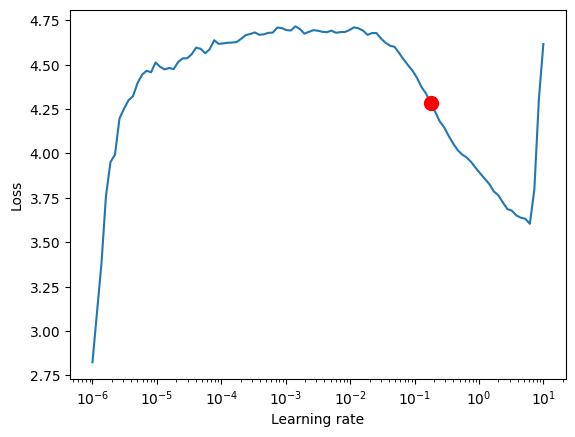

C:\Users\pawel\AppData\Local\Temp\ipykernel_24140\4268711780.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [14]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [15]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cuda",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 9.0k


In [16]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 291    | train
3  | prescalers                         | ModuleDict                      | 160    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 769    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 418    | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 304    | train
8  | static_context_initial_hidden_lstm |

c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 49: 100%|██████████| 50/50 [01:07<00:00,  0.74it/s, v_num=4, train_loss_step=1.530, val_loss=1.210, train_loss_epoch=1.530]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 50/50 [01:07<00:00,  0.74it/s, v_num=4, train_loss_step=1.530, val_loss=1.210, train_loss_epoch=1.530]


In [13]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=10,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2024-06-24 13:47:15,903] A new study created in memory with name: no-name-5888422b-c1a2-4155-b13f-1af51e0da68a
c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:124: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\tuning.py:148: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout=trial.suggest_uniform(

{'gradient_clip_val': 0.03056867780711518, 'hidden_size': 74, 'dropout': 0.20832964611002608, 'hidden_continuous_size': 41, 'attention_head_size': 3, 'learning_rate': 0.023931427789895203}


In [14]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [15]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\lightning\pytorch\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
c:\Users\pawel\.conda\envs\PyTorchGPU\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


tensor(2.2040)

In [16]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


IndexError: index 1 is out of bounds for dimension 0 with size 1

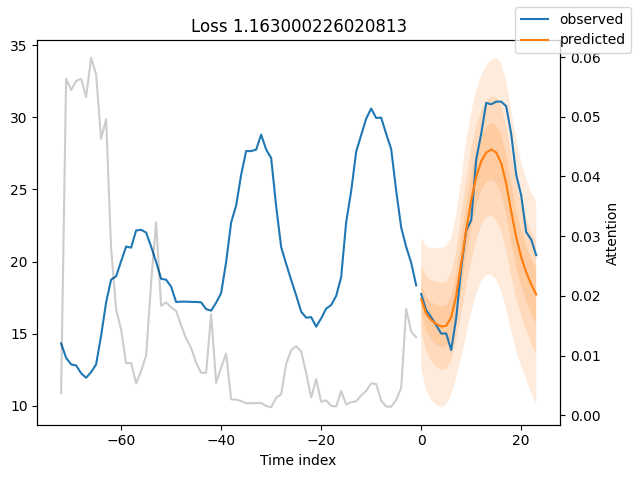

In [17]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'time_idx': <Figure size 1000x500 with 2 Axes>,
 'temperature_c': <Figure size 1000x500 with 2 Axes>,
 'apparent_temperature_c': <Figure size 1000x500 with 2 Axes>,
 'humidity': <Figure size 1000x500 with 2 Axes>,
 'wind_speed_km_h': <Figure size 1000x500 with 2 Axes>,
 'wind_bearing_degrees': <Figure size 1000x500 with 2 Axes>,
 'visibility_km': <Figure size 1000x500 with 2 Axes>,
 'loud_cover': <Figure size 1000x500 with 2 Axes>,
 'pressure_millibars': <Figure size 1000x500 with 2 Axes>,
 'constant': <Figure size 640x480 with 2 Axes>,
 'month': <Figure size 1000x500 with 2 Axes>,
 'summary': <Figure size 1000x500 with 2 Axes>,
 'precip_type': <Figure size 640x480 with 2 Axes>}

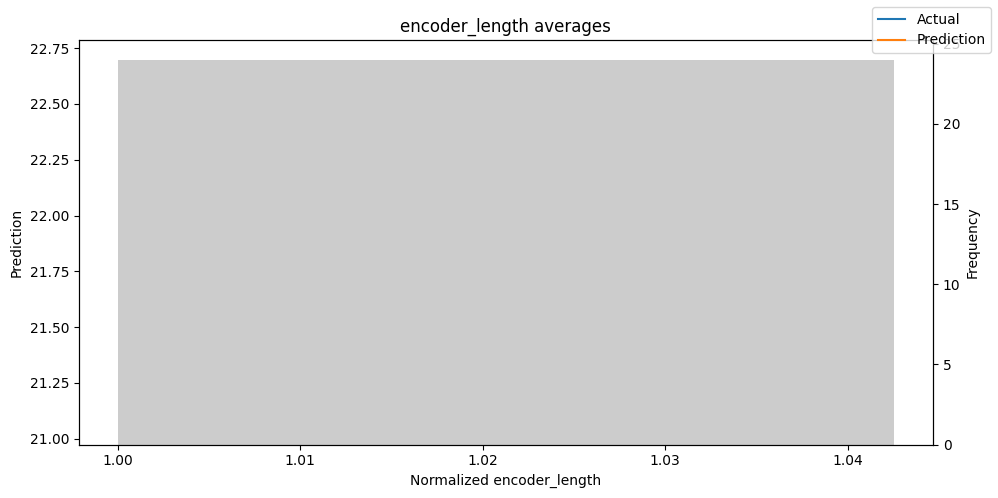

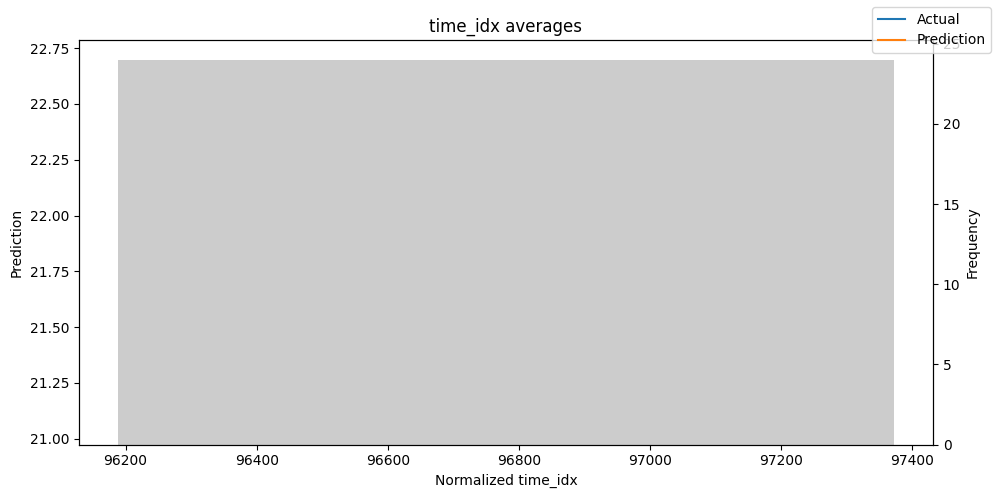

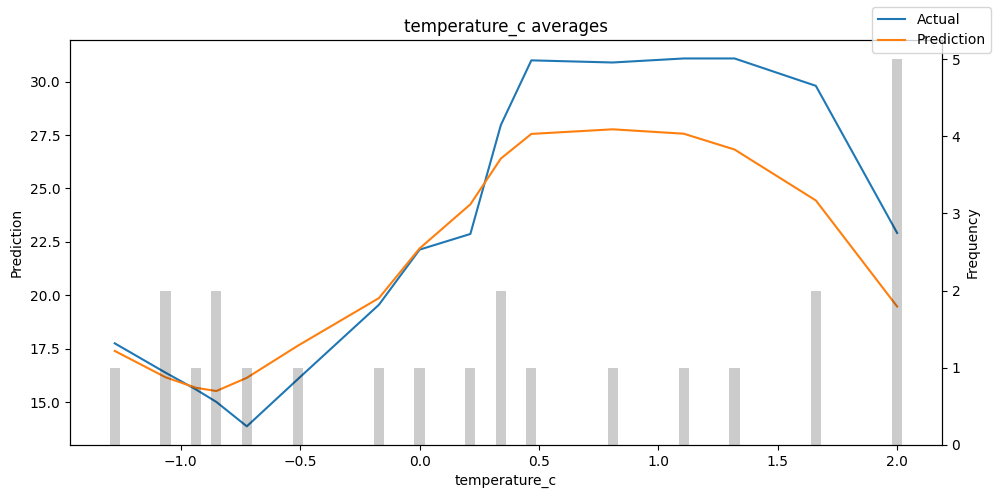

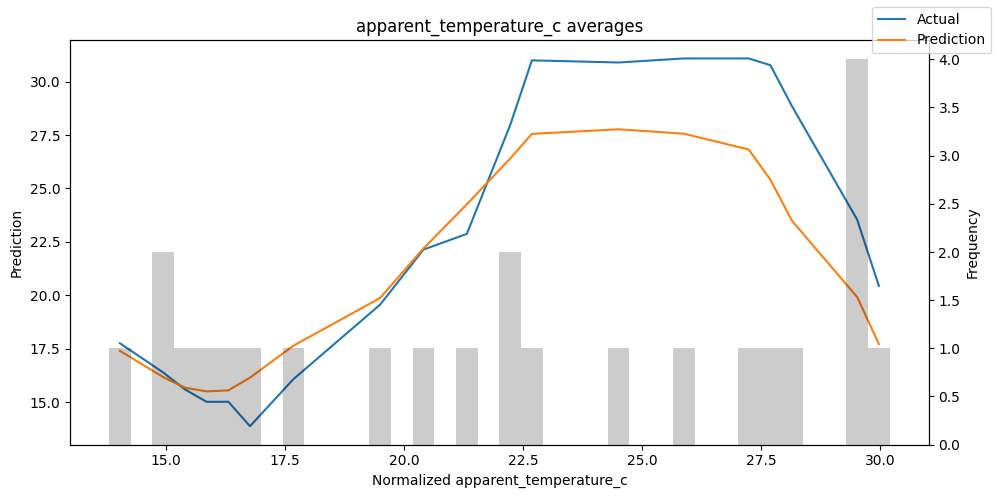

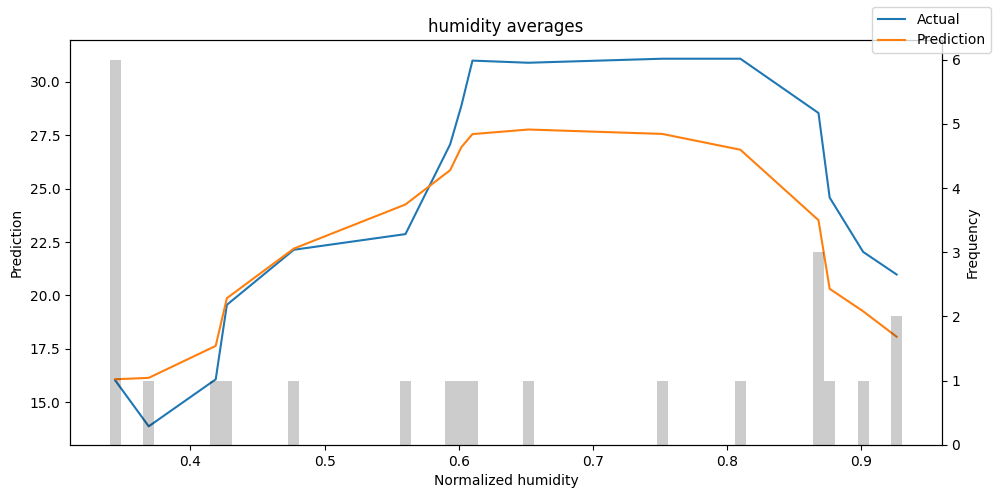

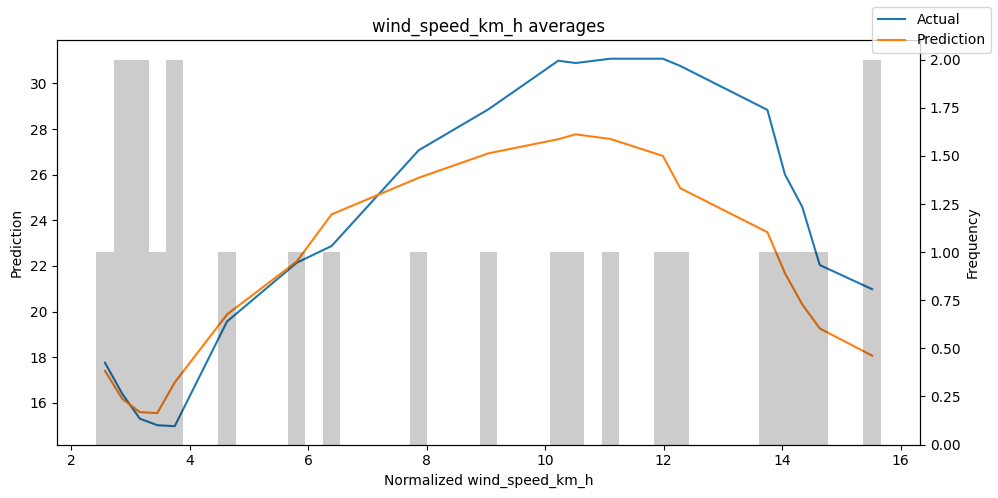

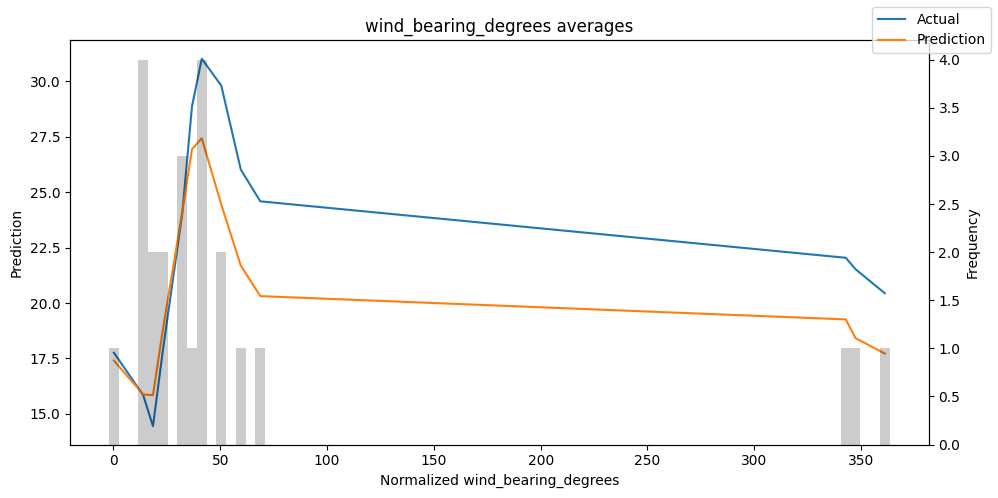

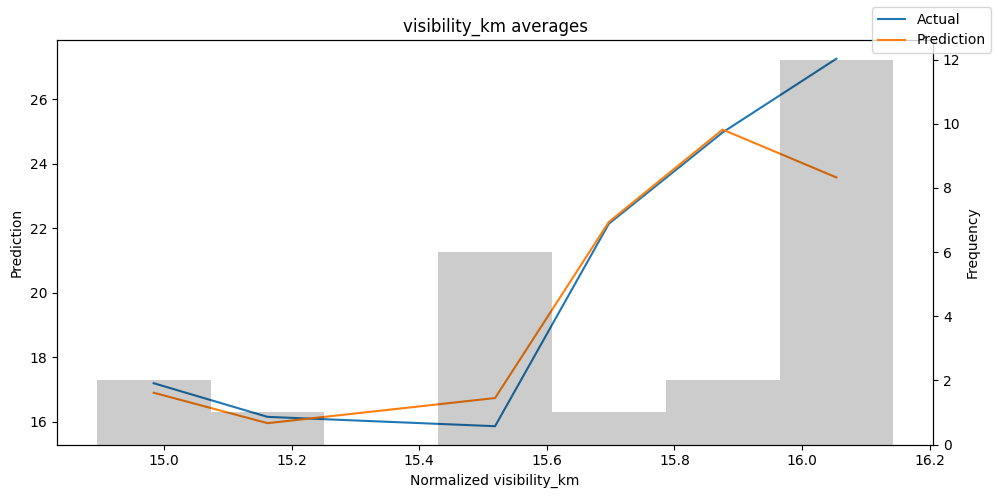

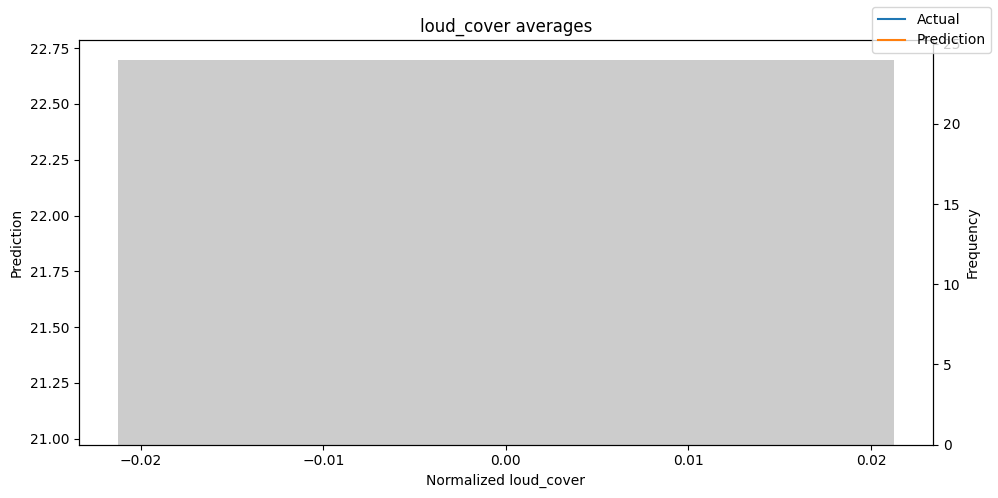

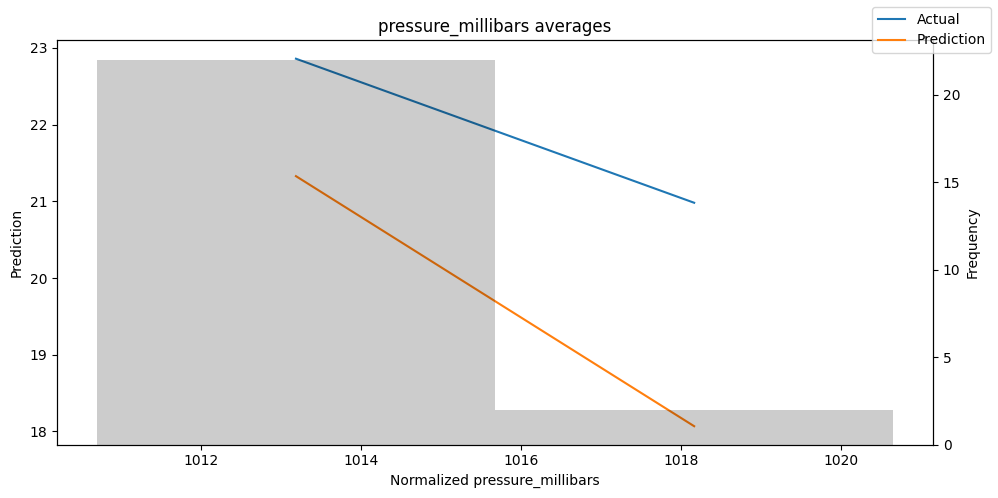

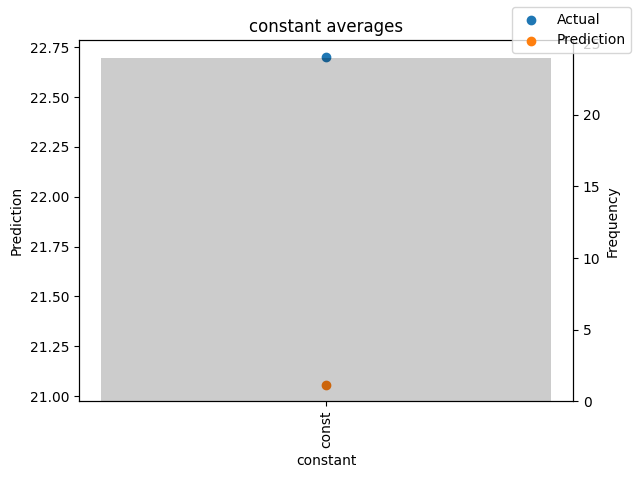

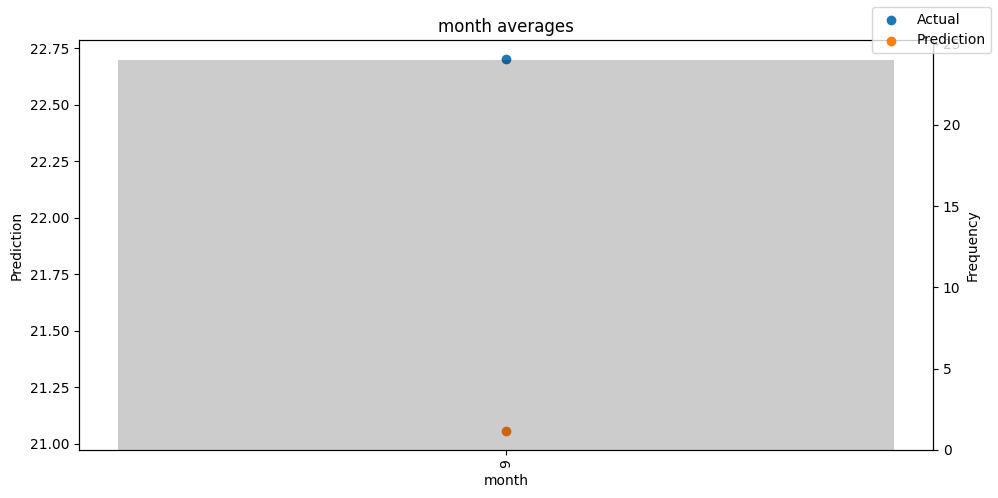

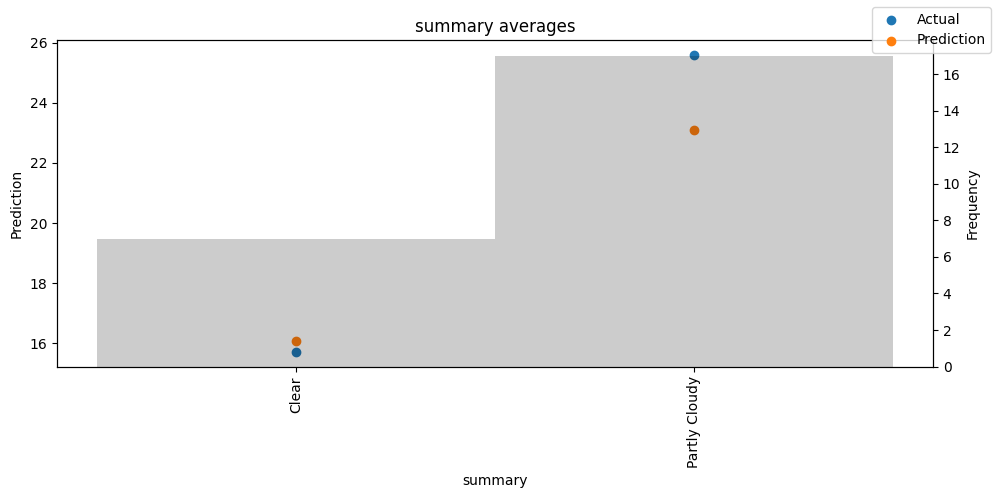

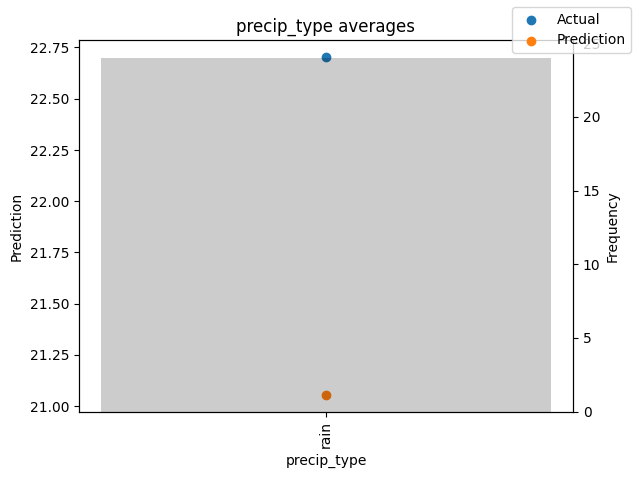

In [18]:
predictions = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x500 with 1 Axes>,
 'decoder_variables': <Figure size 700x250 with 1 Axes>}

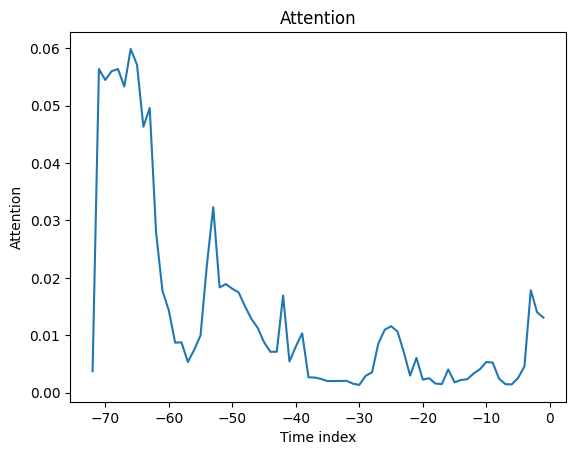

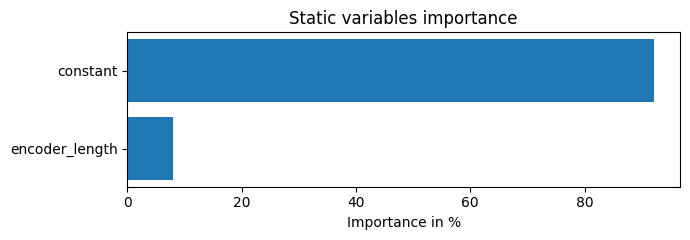

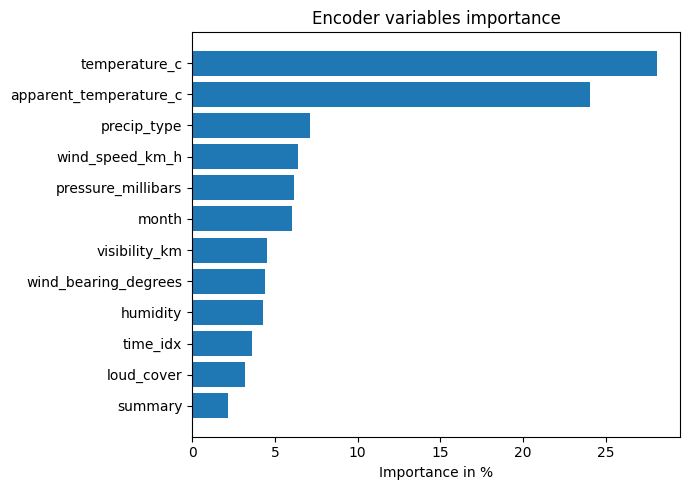

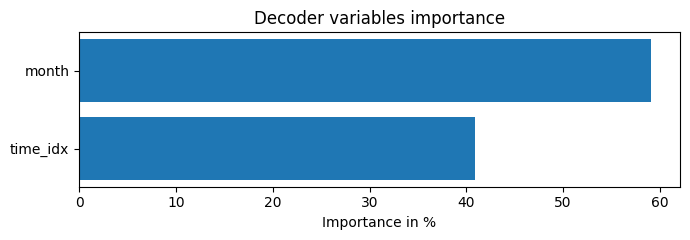

In [19]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)